
# B.8. Pre-Calibration Tutorial for Coupled Human-Water Systems Modeling

This notebook demonstrates a precalibration workflow for coupled human-water systems modeling. 

To avoid long runtimes, we provide pre-generated simulation results so users can focus on experiencing the precalibration workflow and analyzing the outcomes. The simulation code is provided at the end of this notebook, allowing users to run the model on their own local machine if preferred.

The code block below is to setup the environment.

In [1]:
# Install and load packages

# Install packages if not already installed
#!pip install pathnavigator
import os
root_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
import pathnavigator

#root_dir = rf"{pathnavigator.__path__[0]}/.."
pn = pathnavigator.create(root_dir)
pn.chdir()
print(pn.get())  # Check working directory

c:\Users\CL\Documents\GitHub\PreCalibration-CoFlow


## B.8.1 Why Pre-Calibration?

Before jumping into "how" to do the pre-calibration, let's start by answering "why" we may need this technique.

Pre-calibration is a pragmatic, flexible, and low-cost alternative, especially in the following situations:

- Models are computationally expensive

If a model take a long time to run, even for just a minute, the computational cost may not be feasible for Markov Chain Monte Carlo (MCMC) or full Bayesian inference as the number of model evaluations (in the scale of tens of thousands to millions) in those more formal uncertainty quantification techniques is much higher than what pre-calibration is required.

- Full probabilistic treatment is unjustified or infeasible

Many complex simulation models, especially those involving human decision-making or agent-based behaviors, lack an explicit or tractable likelihood function. This makes it difficult or impossible to formally apply Bayesian inference methods, which rely on the likelihood to update prior beliefs. For example, agent-based models may include discrete, rule-based decisions and path dependencies that don’t lend themselves to a mathematically smooth or differentiable likelihood surface.

- The problem space is large and uncertain

Many models are structurally complex and include numerous parameters, often with limited observational data to constrain them, which is often the case for human-water systems modeling. A full probabilistic approach would require defining priors and exploring joint distributions over potentially under-informed parameters, which could lead to unidentifiable or non-informative posteriors. The equifinality phenonminon, where multiple model configurations result in similar outcomes, add another layer of complexity and difficulty in uncertainty quantification.

- Decision-makers may require rapid insights

In some cases, decision-makers may require rapid insights or robustness testing over a range of plausible futures, rather than full posterior distributions. Pre-calibration offers a practical compromise that it helps filter implausible parameter sets based on observed behavior, enabling focused exploration while avoiding overcommitment to unjustified assumptions.

## B.8.2 Pre-Calibration in Coupled Human-Water Systems Modeling

Moving toward the "how" question, we want to learn how the conventional parameterization works for constructing a coupled human-water model then gradually look into what pre-calibration strategies we could use to reveal the uncertainty of the model.

Given the complexity of coupled human-water model, often time a single best model configuration is picked from the component-wise model calibration. The uncertainty of this type of the model is then solely built from its stochatic nature in the model design. From the model configuration perspective, this can be view as a deteministic best model which ignore the uncertainty that could be brought by parameter uncertainty.

**Why parameter uncertainty matter in human-water systems modeling context?**

Assuming we have a coupled model consists of a semi-distributed hydrological model and an agent-based model (ABM) where each agent may interact with different subbasins as well as other agents. Now, we could calibrate the hydrological model and ABM seperately using the available data. Suppose we pick a hydrological model that performed the best on a choosen error metric at the basin outlet and coupled with an ABM to evaluate a water conservation policy, what we ignore is the potential equifinal parameter configurations. Those equifinal hydrological models may have similar performance at the outlet but may vary in their subbasin-level hydrological responses. Remembering that agents are interacting with subbasins, the policy evaluation results derive from the coupled model simulation in this case may have significant uncertainty. 

**Pre-Calibration Strategies**

Instead of using single best model configuration, this tutorial will walk you through how to reveal the parameter uncertainty through pre-calibration technique. Specifically, we want to compare two pre-calibration strategies: one is to conduct a component-wise pre-calibration the other is pre-calibration over a coupled model.

If both stratgies achieve similar uncertainty information, component-wise pre-calibration maybe a more computationally efficienct workflow given a parameter sampling space is smaller compared to the full coupled model.

Now, let's start the tutorial by introducing a coupled human-water model, CoFlow, that we will used as an example.

## B.8.3 CoFlow Model

CoFlow is a stylized human water system model inspired by Yakima River Basin (YRB) in Washinton State. CoFlow is built by HydroCNHS python package (Lin et al., 2022) that comprises a semi-distributed hydrological model and an ABM to describe five irrigation district annual diversion behaviors under the basin-wide water conservation program. 

![](images\yrb.jpg)
Figure 1. Conceptualization of a human-water system inspired by Yakima River Basin.

The water conservation program are represented by gradually increase summer flow target at gauge G. 

![](images\conservation_policy.jpg)

Figure 2. Illustration of water conservation policy, represented by gradually increase summer flow target at gauge G.

We briefly walk you through the model structural design in the following sections.

### Hydrological model
Each subbasin's runoff responses are simulated using Generalized Watershed Loading Functions (GWLF; Haith & Shoemaker, 1987; Tung & Haith, 1995) where the routing process are computed by the Lohmann routing model (Lohmann et al., 1998; Wi et al., 2015). The parameters are shown below.

Table 1. Hydrological model parameters
| Model              | Sub-model        | Parameter name                                 | Unit     | Code |
|--------------------|------------------|--------------------------------------------------|----------|------|
| Hydrological model | GWLF             | Curve number                                     | –        | $CN2$  |
|                    |                  | Interception coefficient                         | –        | $IS$   |
|                    |                  | Recession coefficient                            | –        | $Res$  |
|                    |                  | Deep seepage coefficient                         | –        | $Sep$  |
|                    |                  | Baseflow coefficient                             | –        | $α$    |
|                    |                  | Percolation coefficient                          | –        | $β$    |
|                    |                  | Available/soil water capacity                    | Cm       | $Ur$   |
|                    |                  | Degree-day coefficient for snowmelt              | cm/°C    | $Df$   |
|                    |                  | Land cover coefficient                           | –        | $Kc$   |
|                    | Lohmann routing  | Subbasin unit hydrograph shape parameter         | –        | $Gs$   |
|                    |                  | Subbasin unit hydrograph rate parameter          | –        | $Gr$   |
|                    |                  | Wave velocity in the linearized Saint–Venant eq. | m/s      | $Ve$  |
|                    |                  | Diffusivity in the linearized Saint–Venant eq.   | m²/s     | $Di$   |

### ABM
Each agent in ABM simulate one of the five irrigation district's diversion behavior. It will make annual diversion request decision in March every year. In the designed ABM used in this tutorial, we assume agent can learn from the long-term envioronmental changes based on the flow target violation feedback and adapt to short-term shocks using the forecast water availability represented by the precipitation during the winter and spring period given that the streamflow is main supply by the snow melt.

Essentially, diversion agents'  have learning, adaptive, and drought response elements involve in their decision-making procedure. For detailed calculation please refer to (Lin & Yang, 2022). Here we would like to provide you a high level understanding on agent decision-making procedure.

#### Learning

The diversion request decision procedure start with adjusting diversion request references ($Div_{req,ref}$) from the flow deviation of the flow target capturing agent's learning ability.

$$
Div_{\text{req,ref},y} = Div_{\text{req,ref},y-1} + V_{\text{avg},y} \times \gamma
$$

$$
V_{\text{avg},y} = \frac{1}{10} \sum_{i=1}^{10} V_{y-i}
$$

where $ \gamma $ is a learning rate, subscript $ y $ denotes the year, and $ V_{\text{avg}} $ is the average strength value, with a 10-year rolling window indicating the magnitude and learning direction (e.g., increase $ Div_{\text{req,ref},y} $ if $ V_{\text{avg},y} $ is positive, or decrease $ Div_{\text{req,ref},y} $ if $ V_{\text{avg},y} $ is negative).

This 10-year rolling window also creates learning momentum in the learning direction of $ Div_{\text{req,ref}} $, where $ V_{\text{avg}} $ needs several (consecutive) counter events (e.g., $ V = 1 $ when $ V_{\text{avg}} < 0 $ or $ V = -1 $ when $ V_{\text{avg}} > 0 $) to reverse its sign (i.e., learning direction of $ Div_{\text{req,ref}} $).

The events are denoted as $V$ and calculated by:

$$
V_y = 
\begin{cases} 
1 & \text{if } |De_y| > L_u \text{ and } De_y > 0 \\
-1 & \text{if } |De_y| < L_l \text{ and } De_y < 0 \\
0 & \text{otherwise}
\end{cases}
$$

$$
De = Q_{789} - Q_{\text{target}} 
$$

where $ L_u $ and $ L_l $ are the upper and lower flow deviation thresholds, respectively. These two parameters control how sensitive an agent is to wet or dry hydrological conditions. $ De $ is the deviation of the average flow from July to September ($ Q_{789} $) relative to the flow target ($ Q_{\text{target}} $).

![](images\learning.jpg)

Figure 2. Illustration of learning mechanism adopted from Lin et al., (2022).

#### Adapting
Then, the updated $ Div_{\text{req,ref},y} $ will be further adjusted according to available water, which is approximated by the precipitation from Nov to Jun, through a quadratic function as shown below.

$$
Div_{\text{req,mu},y} = Div_{\text{req,ref},y} + a \times P_{11{-}6,y}^2 + b \times P_{11{-}6,y} + c
$$

#### Drought response
If a drought occurs defined as $ P_{11{-}6,y} < 315 mm $, the adaptative behavior above will be replaced by a fixed prorated ratio ($ R $).

$$
Div_{\text{req,mu},y} = Div_{\text{req,ref},y} \times R
$$

Finally, the interaction among farmers are described by covariance matrix fitted by historical diversion data.

$$
Div_{\text{req},y} = Div_{\text{req,mu},y} + Rn \times Sig
$$

where $ Rn $ is a random number draw from the multivariate normal distribution scaled by $ sig $. The requested diversion ($Div_{\text{req}}$) is disaggregated into a daily scale based on historical monthly reduction proportions to continue the simulation. 

The return flow ($Q_{r,d}$) is computed from the actual diversion ($Div_d$) as shown below:

$$
Q_{r,d} = frout(R_f \times Div_d) 
$$

where $frout(\cdot)$ represents the routing process within the subbasin of the returned outlet, $R_f$ is the return flow factor, and the subscript $d$ denotes the day.


The table below summarize the parameters involved in ABM calculation.

Table 2. ABM parameters
| Parameter Description                          | Unit         | Symbol     |
|-----------------------------------------------|--------------|------------|
| Return flow factor                             | –            | $R_f$      |
| Upper flow deviation threshold                 | m³/s         | $L_U$      |
| Lower flow deviation threshold                 | m³/s         | $L_L$      |
| Learning rate                                  | –            | $\gamma$   |
| Standard deviation modifier                    | m³/s         | $Sig$      |
| Prorated ratio                                 | –            | $R$        |
| Quadratic coefficient of quadratic model       | m³/s/cm²     | $a$      |
| Slope of quadratic model                       | m³/s/cm      | $b$      |
| Intercept of quadratic model                   | m³/s         | $c$      |

Putting all things together, here show you how to run the model.

In [ ]:
# Install packages if not already installed
#!pip install hydrocnhs
import hydrocnhs
pn.src.add_to_sys_path()
from src.utils import InputBuilder

# Load inputs
folder = "coflow_example"
input_file = "inputs_yrb_coupledABM_1979_2023.h5"
inputs_path = pn.get(folder, input_file)
ib = InputBuilder(root_dir)
inputs = ib.load_hdf5(inputs_path)

temp = inputs["temp"]
prec = inputs["prec"]
pet = inputs["pet"]
obv_flow = inputs["obv_flow"]
obv_div = inputs["obv_div"]

# Load model and set the path in the model configuration file
model_path = pn.get(folder, "yrb_coupledABM_GWLF_134742_2.yaml")
model_dict = hydrocnhs.load_model(model_path)
model_dict["Path"]["WD"] = pn.get()
model_dict["Path"]["Modules"] = pn.src.get()

# Create model instance
model = hydrocnhs.Model(model_dict, "coflow_example")
#model.paral_setting = {'verbose': 0, 'cores_pet': 1, 'cores_formUH': 1, 'cores_runoff': 1}

# Set assigned_Q
# This is an extra step. Since the reservoir releases are given as inputs, we don't need 
# to simulate the inflows to reservoirs (i.e., discharge of subbasins S1, S2, S3). 
# Therefore, we set the inflows for all reservoirs to zero. 
l = model_dict["WaterSystem"]["DataLength"]
assigned_Q = {sub: [0]*l for sub in ["S1","S2","S3"]}

#%% Run the model
Q = model.run(temp, prec, pet, assigned_Q)
print(Q["G"])

hydrocnhs_example: 100%|██████████| 16436/16436 [00:05<00:00, 3012.53it/s]

## B.8.4 Error and Management Metrices

We adopted a widely used error metric, Kling–Gupta Efficiency (KGE; Gupta et al., 2009), to evaluate model performance. 
The metric decomposes performance into three components—correlation, bias, and variability—allowing a balanced assessment of model skill. It is defined as

$$
KGE = 1 - \sqrt{(r - 1)^2 + \left(\frac{\mu_s}{\mu_o} - 1\right)^2 + \left(\frac{\sigma_s/\mu_s}{\sigma_o/\mu_o} - 1\right)^2 },
$$

where $r$ is the linear correlation coefficient between observed ($o$) and simulated ($s$) values, $\mu$ denotes the mean, and $\sigma$ the standard deviation. The second term $\mu_s / \mu_o$ represents the bias ratio, which measures how well the mean of the simulations matches that of the observations. The third term is the variability ratio, expressed as the ratio of the coefficients of variation $(\sigma/\mu)$ between simulated and observed data, which quantifies the relative spread of values. A value of $KGE = 1$ indicates perfect agreement, whereas lower values reflect increasing deviations due to errors in correlation, bias, or variability.

Given the summer flow (Jul, Aug, Sep) at gauge G is the most conversation policy relevant indicator, we defined $KGE_{summer_flow}$ as a key error metric that will be used to select plausible models.

From the management perspective, we focus on annual flow target violation at gauge G, defined as 

## B.8.5 Latin Hyper Cube (LHC) Sampling on the Selected Parameters 

The parameter space of the CoFlow Model is relatively large with total 89 parameters.
Navigating through such a large parameter space is not efficient for tutoring purposes. Based on our prior knowledge, we down selected to 32 parameters, including 4 parameters from each of the three subbasins and 4 parameters from each of the five agents as shown in the following figure.

![](images\selected_par.jpg)

Figure 4. Selected CoFlow Model parameters for this tutorial.

Then, we adopted LHC sampling technique to sample 100,000 samples for each of the experiments introduced the the next section.


Below is the upper and lower bounds of the selected parameters used in this tutorial. 

Table 3. Lower and upper bounds of the selected CoFlow Model parameters.
| Parameter Name |   Lower Bound |   Upper Bound |
|----------------|---------------|---------------|
| Alpha\|C1      |         0     |         0.03  |
| Beta\|C1       |         0.032 |         0.062 |
| Ur\|C1         |        12.27  |        13.67  |
| Df\|C1         |         0.9   |         1     |
| Alpha\|C2      |         0.023 |         0.053 |
| Beta\|C2       |         0.274 |         0.304 |
| Ur\|C2         |        13.6   |        15     |
| Df\|C2         |         0.141 |         0.241 |
| Alpha\|G       |         0.004 |         0.034 |
| Beta\|G        |         0     |         0.03  |
| Ur\|G          |         2.834 |         4.234 |
| Df\|G          |         0     |         0.1   |
| Lr_c\|Kittitas |         0     |         0.6   |
| a\|Kittitas    |       -57.641 |       -50.941 |
| b\|Kittitas    |        56.928 |        63.628 |
| c\|Kittitas    |        -2.975 |        -2.675 |
| Lr_c\|Tieton   |         0     |         0.6   |
| a\|Tieton      |        -1.05  |        -0.95  |
| b\|Tieton      |         1.79  |         1.89  |
| c\|Tieton      |         2.741 |         3.041 |
| Lr_c\|Roza     |         0     |         0.6   |
| a\|Roza        |       -72.877 |       -66.677 |
| b\|Roza        |        68.65  |        75.15  |
| c\|Roza        |        -4.109 |        -3.709 |
| Lr_c\|Wapato   |         0     |         0.6   |
| a\|Wapato      |       -92.231 |       -84.931 |
| b\|Wapato      |        82.508 |        89.808 |
| c\|Wapato      |         3.327 |         3.727 |
| Lr_c\|Sunnyside|         0     |         0.6   |
| a\|Sunnyside   |         5.511 |         6.011 |
| b\|Sunnyside   |         1.766 |         1.866 |
| c\|Sunnyside   |        14.817 |        16.217 |



## B.8.6 Component-Wise Pre-Calibration V.S. Single Best Model Configuration

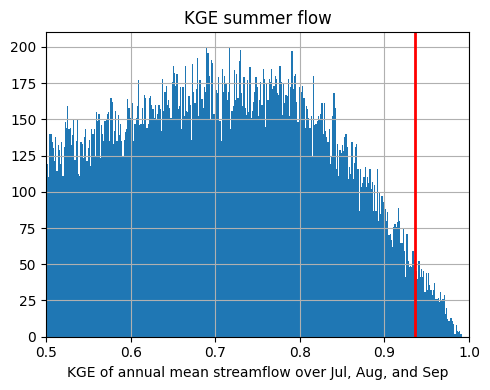

C:\Users\CL\AppData\Local\Temp\ipykernel_24552\4070698248.py:30: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_hy_plausible[ylist].hist(bins=200, ax=ax)


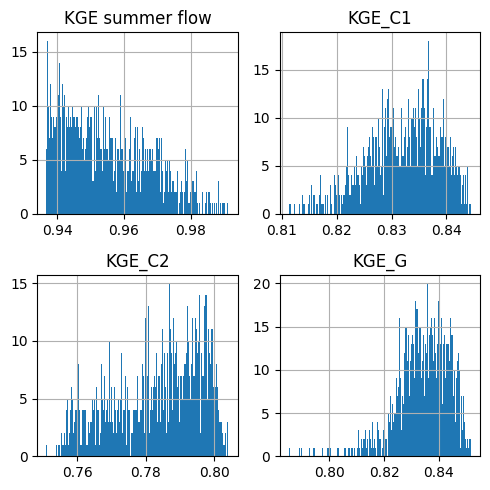

In [8]:
# Precalibration on hydrological model

import matplotlib.pyplot as plt
import numpy as np
from src.utils import read_parquet

folder = "component_wise_precalibration_hy"

df_hy = read_parquet(pn.get(folder, "output", "component_wise_precalibration_hy_135334_metrics.parquet"))
df_hy = df_hy.rename(columns={"KGE_G(789)": "KGE summer flow"})
ylist = ["KGE summer flow", 'KGE_C1', 'KGE_C2', 'KGE_G']

# Select top 1% (N=1000)
q99 = np.quantile(df_hy[["KGE summer flow"]], 0.99)
# 0.9367

#% KGE summer flow
fig, ax = plt.subplots(figsize=(5, 4))
df_hy[["KGE summer flow"]].hist(bins=1000, ax=ax)
ax.set_xlim([0.5, 1])
ax.axvline(q99, c="r", lw=2)
#ax.axvline(0.754, c="orange", lw=2, label="Baseline")
ax.set_xlabel("KGE of annual mean streamflow over Jul, Aug, and Sep")
plt.tight_layout()
plt.show()


df_hy_plausible = df_hy[df_hy["KGE summer flow"] >= q99]
fig, ax = plt.subplots(figsize=(5, 5))
df_hy_plausible[ylist].hist(bins=200, ax=ax)
plt.tight_layout()
plt.show()


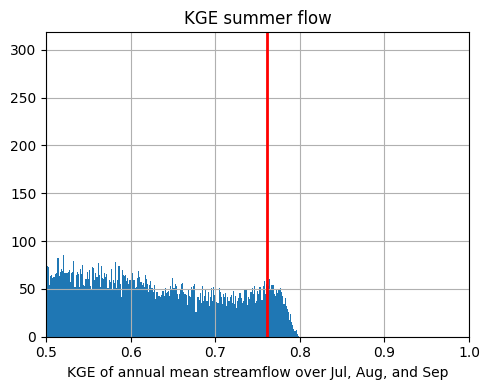

C:\Users\CL\AppData\Local\Temp\ipykernel_24552\1923003742.py:29: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_abm_plausible[ylist].hist(bins=200, ax=ax)


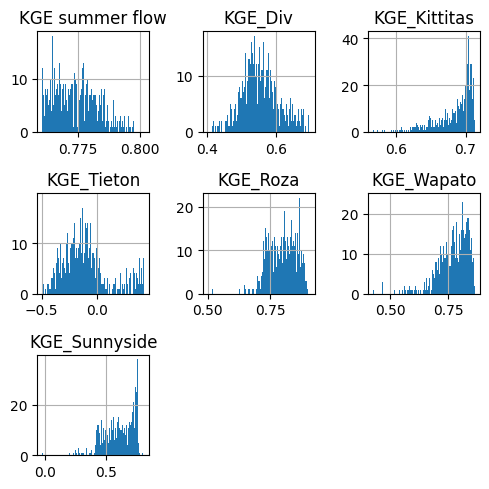

In [9]:
# Precalibration on ABM
import matplotlib.pyplot as plt
import numpy as np
from src.utils import read_parquet

folder = "component_wise_precalibration_abm"

df_abm = read_parquet(pn.get(folder, "output", "component_wise_precalibration_abm_135314_metrics.parquet"))
df_abm = df_abm.rename(columns={"KGE_G(789)": "KGE summer flow"})
ylist = ["KGE summer flow", "KGE_Div", 'KGE_Kittitas', 'KGE_Tieton', 'KGE_Roza', 'KGE_Wapato', 'KGE_Sunnyside']

# Select top 1% (N=1000)
q99 = np.quantile(df_abm[["KGE summer flow"]], 0.99)
# 0.9367

#% KGE summer flow
fig, ax = plt.subplots(figsize=(5, 4))
df_abm[["KGE summer flow"]].hist(bins=1000, ax=ax)
ax.set_xlim([0.5, 1])
ax.axvline(q99, c="r", lw=2)
#ax.axvline(0.754, c="orange", lw=2, label="Baseline")
ax.set_xlabel("KGE of annual mean streamflow over Jul, Aug, and Sep")
plt.tight_layout()
plt.show()


df_abm_plausible = df_abm[df_abm["KGE summer flow"] >= q99]
fig, ax = plt.subplots(figsize=(5, 5))
df_abm_plausible[ylist].hist(bins=200, ax=ax)
plt.tight_layout()
plt.show()

In [15]:
# Deterministic solution
df_hy_best_idx = df_hy[df_hy["KGE summer flow"] == df_hy["KGE summer flow"].max()].index[0]
df_abm_best_idx = df_abm[df_abm["KGE summer flow"] == df_abm["KGE summer flow"].max()].index[0]

print("Best hydrological model index (index={}):".format(df_hy_best_idx))
print("Best ABM model index (index={}):".format(df_abm_best_idx))

sample_hy_best = read_parquet(pn.get("component_wise_precalibration_hy", 'samples.parquet')).loc[df_hy_best_idx, :]
sample_abm_best = read_parquet(pn.get("component_wise_precalibration_abm", 'samples.parquet')).loc[df_abm_best_idx, :]
print("Best hydrological model parameters:\n", sample_hy_best)
print("Best ABM model parameters:\n", sample_abm_best)

sol_deterministic = sample_hy_best.values.tolist() + sample_abm_best.values.tolist()
print("Deterministic solution:\n", sol_deterministic)

Best hydrological model index (index=71191):
Best ABM model index (index=83938):
Best hydrological model parameters:
 Alpha|C1     0.009327
Beta|C1      0.051953
Ur|C1       12.895579
Df|C1        0.917720
Alpha|C2     0.031455
Beta|C2      0.280187
Ur|C2       14.891298
Df|C2        0.192161
Alpha|G      0.006282
Beta|G       0.011335
Ur|G         3.653291
Df|G         0.029124
Name: 71191, dtype: float64
Best ABM model parameters:
 Lr_c|Kittitas      0.277226
a|Kittitas       -54.459080
b|Kittitas        61.444570
c|Kittitas        -2.937564
Lr_c|Tieton        0.026969
a|Tieton          -1.000357
b|Tieton           1.879069
c|Tieton           2.900745
Lr_c|Roza          0.116581
a|Roza           -67.628650
b|Roza            71.520592
c|Roza            -4.098586
Lr_c|Wapato        0.073296
a|Wapato         -89.611546
b|Wapato          84.067684
c|Wapato           3.422900
Lr_c|Sunnyside     0.005756
a|Sunnyside        5.554395
b|Sunnyside        1.840722
c|Sunnyside       15.965411
Na

In [ ]:
# Simulate the deterministic best solution
import hydrocnhs
pn.src.add_to_sys_path()
from src.utils import InputBuilder

# Load inputs
folder = "coflow_deterministic_best"
input_file = "inputs_yrb_coupledABM_1979_2023.h5"
inputs_path = pn.get(folder, input_file)
ib = InputBuilder(root_dir)
inputs = ib.load_hdf5(inputs_path)

temp = inputs["temp"]
prec = inputs["prec"]
pet = inputs["pet"]
obv_flow = inputs["obv_flow"]
obv_div = inputs["obv_div"]

# Load model and set the path in the model configuration file
model_path = pn.get(folder, "yrb_coupledABM_GWLF_134742_2.yaml")
model_dict = hydrocnhs.load_model(model_path)
model_dict["Path"]["WD"] = pn.get()
model_dict["Path"]["Modules"] = pn.src.get()

# Assign the parameters to the model configuration

# Create model instance
model = hydrocnhs.Model(model_dict, "coflow_deterministic_best")
#model.paral_setting = {'verbose': 0, 'cores_pet': 1, 'cores_formUH': 1, 'cores_runoff': 1}

# Set assigned_Q
# This is an extra step. Since the reservoir releases are given as inputs, we don't need 
# to simulate the inflows to reservoirs (i.e., discharge of subbasins S1, S2, S3). 
# Therefore, we set the inflows for all reservoirs to zero. 
l = model_dict["WaterSystem"]["DataLength"]
assigned_Q = {sub: [0]*l for sub in ["S1","S2","S3"]}

#%% Run the model
Q = model.run(temp, prec, pet, assigned_Q)
print(Q["G"])

hydrocnhs_example: 100%|██████████| 16436/16436 [00:07<00:00, 2283.32it/s]


[ 8.4312808  11.38924587 12.43066296 ... 71.08332904 78.18764921
 78.45790385]


In [48]:
# Calculate error metric for the determisnistic best solution
import pandas as pd
sim_Q_D = pd.DataFrame(Q, index=model.pd_date_index)
sim_Q_M = sim_Q_D.resample("MS").mean()
pd_date_M_index = sim_Q_M.index

start_date = '1980-01-01'
end_date = '2023-12-31'
sim_Q_M = sim_Q_M[start_date:end_date]
obv_flow = obv_flow[start_date:end_date]

mask = [True if i.month in [7,8,9] else False for i in sim_Q_M.index]
Q_summer = sim_Q_M[mask].resample("YS").mean()["G"]
indicator = hydrocnhs.Indicator()
kge_g_summer = indicator.get_kge(x_obv=obv_flow[mask].resample("YS").mean()["G"], y_sim=Q_summer, r_na=True)
print("KGE of annual mean streamflow over Jul, Aug, and Sep:", kge_g_summer)
Q_summer.rename("G789", inplace=True)
obv_Q_summer = obv_flow[mask].resample("YS").mean()["G"]
obv_Q_summer.rename("obv_G789", inplace=True)

ag_list = ['Kittitas', 'Tieton', 'Roza', 'Wapato', 'Sunnyside']
shortage_M = pd.DataFrame(index=pd_date_M_index)
div_D = pd.DataFrame(index=model.pd_date_index)
for ag in ag_list:
    shortage_M[ag] = model.dc.get_field(ag)["Shortage_M"]
    div_D[ag] = model.dc.get_field(ag)["Div"]
obv_div = obv_div[start_date:end_date]
div_Y = div_D.resample("YS").mean()[start_date:end_date]
div_Y["Div"] = div_Y[ag_list].sum(axis=1)
obv_div_Y = obv_div.resample("YS").mean().sum(axis=1)
obv_div_Y.rename("obv_Div", inplace=True)

df_ts_deterministic_best = pd.concat([Q_summer, obv_Q_summer,div_Y, obv_div_Y], axis=1)
df_ts_deterministic_best.to_csv(pn.get("coflow_deterministic_best", "output") / "deterministic_best_ts.csv")

KGE of annual mean streamflow over Jul, Aug, and Sep: 0.7819977392610461


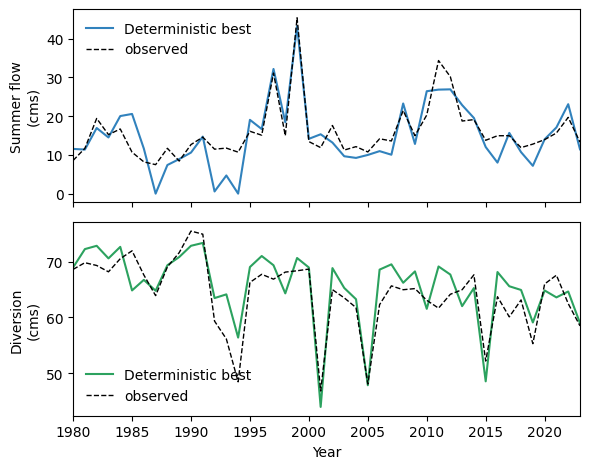

In [50]:
from cmap import Colormap
df_ts_deterministic_best = pd.read_csv(pn.get("coflow_deterministic_best", "output") / "deterministic_best_ts.csv", index_col=0, parse_dates=True)
df_ts_deterministic_best.index = df_ts_deterministic_best.index.year
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), sharex=True)
cm_br = Colormap('colorbrewer:Blues_6')
cm_gr = Colormap('colorbrewer:BuGn_6')

i = 1
colors = [cm_br(i*2+2), cm_gr(i*2+2)]
variables = ['G789', 'Div']  
names = {"G789": "Summer flow\n(cms)", "Div": "Diversion\n(cms)"}
label = "Ensembles"
for ax, col, color in zip(axes, variables, colors):
    # Plot mean line
    ax.plot(df_ts_deterministic_best.index, df_ts_deterministic_best[col], color=color, linestyle='-', label="Deterministic best")
    ax.plot(df_ts_deterministic_best.index, df_ts_deterministic_best["obv_"+col], color="k", linestyle='--', lw=1, label="observed")
    ax.set_ylabel(names[col])
    ax.set_xlim([1980, 2023])

axes[0].legend(frameon=False, fontsize=10)
axes[1].legend(frameon=False, fontsize=10)
# Common X label and title
axes[1].set_xlabel("Year")
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

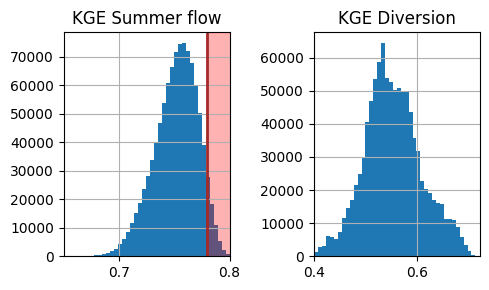

In [ ]:
folder = "component_wise_precalibration_hyabm"
df_ensemble = read_parquet(pn.get(folder, "output", "component_wise_precalibration_hyabm_135347_metrics.parquet"))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))

df_ensemble[["KGE_G(789)", "KGE_Div"]].hist(bins=50, ax=axes)

ax = axes[0]
ax.set_title("KGE Summer flow")
ax.axvline(0.78, c="brown", lw=2, label="Deterministic best")
ax.axvspan(0.78, ax.get_xlim()[1], color='red', alpha=0.3)  # shaded region
ax.set_xlim((0.65, 0.8))

ax = axes[1]
ax.set_title("KGE Diversion")
#ax.axvline(0.6, c="r")
#ax.axvspan(0.6, ax.get_xlim()[1], color='red', alpha=0.3)  # shaded region
ax.set_xlim((0.4, 0.72))

plt.tight_layout()
plt.show()

Ignore the the better combination where coupled structure play a role

Uncertainty

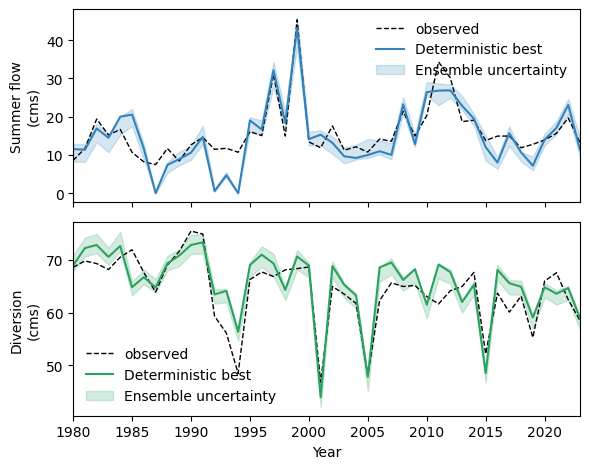

In [51]:
#%% Plot ts uc comparison
from src.plots import add_flow_div_ts_with_uc
df_ts_ensemble = pd.read_parquet(pn.get(folder, "output", "component_wise_precalibration_hyabm_135347_ts_selected.parquet"))
df_ts_ensemble['Year'] = df_ts_ensemble.index.year
df_ts_deterministic_best = pd.read_csv(pn.get("coflow_deterministic_best", "output") / "deterministic_best_ts.csv", index_col=0, parse_dates=True)
df_ts_deterministic_best.index = df_ts_deterministic_best.index.year

from cmap import Colormap
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), sharex=True)
cm_br = Colormap('colorbrewer:Blues_6')
cm_gr = Colormap('colorbrewer:BuGn_6')

i = 1
colors = [cm_br(i*2+2), cm_gr(i*2+2)]
variables = ['G789', 'Div']  
names = {"G789": "Summer flow\n(cms)", "Div": "Diversion\n(cms)"}
label = "Ensembles"
for ax, col, color in zip(axes, variables, colors):
    grouped = df_ts_ensemble.groupby('Year')[col]
    mean = grouped.mean()
    std = grouped.std()
    
    # Plot mean line
    ax.plot(df_ts_deterministic_best.index, df_ts_deterministic_best["obv_"+col], color="k", linestyle='--', lw=1, label="observed")
    ax.plot(df_ts_deterministic_best.index, df_ts_deterministic_best[col], color=color, linestyle='-', label="Deterministic best")
    
    # Plot uncertainty
    lower = mean - 2 * std
    upper = mean + 2 * std
    ax.fill_between(mean.index, lower, upper, alpha=0.2, color=color, label="Ensemble uncertainty")


    ax.set_ylabel(names[col])
    ax.set_xlim([1980, 2023])

axes[0].legend(frameon=False, fontsize=10)
axes[1].legend(frameon=False, fontsize=10)
# Common X label and title
axes[1].set_xlabel("Year")
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [39]:
mean.index

Index([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
      dtype='int32', name='Year')

## B.8.7 Comparison between Component-Wise and As-a-Whole Pre-Calibration

## B.8.8 (Optional) Simulation Code



## B.8.2 Impacts of Pre-Calibration Strategies on Uncertainty Analysis in Coupled Human-Water Modeling

- Show the findings of our experiment first
- Brings out the experiment designs => Three pre-calibration strategies

## B.8.3 CoFlow Model: A Coupled Flow and Behavior Modeling Framework Inspired by the Yakima River Basin

- Introducing the modeling setup and management problem in the YRB

## B.8.4 Error Metrics V.S. Management Metrices

- Introducing the metrics that we used in this analysis and their implications

## B.8.5 Identifying Plausible Hydrological Models

## B.8.6 Identifying Plausible Agent-Based Models

## B.8.7 Pre-calibration with Hydrological Model Ensembles x Agent-Based Model Ensembles

## B.8.8 Pre-calibration with Full CoFlow Model

## B.8.9 Comparison over Pre-Calibration Strategies and Their Policy Implications

## B.8.10 (Optional) Simulation Code 
